Let's implement Eigenvector Continuation (EC) via Quantum computing.  First things first, we must generate the state vectors associated with the ground states of our n sample points.  The specific problem we shall be looking at is for LiH, the same one shown in the Qiskit textbook.  Our goal will be to show the power of EC by taking our sample points for larger atomic distances, where the calculation is inherently easier, and display that this provides enough information to account for the complex behavior seen for smaller interatomic distances.

First, we feature the same problem solved entirely using VQE.  This will be used as reference for later.

In [30]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # this is to ignore the DeprecationWarnings that appear

In [2]:
# This function allows us to extract the relevant qubit operator and info needed to run VQE

def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [3]:
# Next, lets go ahead and create a function to give us the VQE results for our sample points (where interatomic distance
# is our parameter that we are varying)

def VQE_run(dist):
    
    ## Preliminary Things
    backend = BasicAer.get_backend('statevector_simulator')
    optimizer = SLSQP(maxiter=5)
    
    ## Get qubitOp and other useful quantities
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    
    ## Encode initial state and variational form
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    
    ## Now run VQE to get groundstate eigenvalue and optimal parameters associated with the statevector
    vqe = VQE(qubitOp, var_form, optimizer)
    result = vqe.run(backend)
    E0 = np.real(result['eigenvalue'] + shift)
    params = result['optimal_point']
    
    return params, E0

Next, we need code to orthonormalize our states using GSO.  The functions to do this are below.

In [4]:
# To proceed, we will need a function that converts to binary, potentially with additional zeros padded on the end
def binary(num, dig):
    # converts integer, num, to binary with a fixed number of digits, dig
    
    ret = str(bin(num))[2:] # generates number in binary
    if len(ret) > dig:
        print('This is an error, returning zeros by default')
        ret = '0' * dig
    else:
        add_zeros = '0' * (dig - len(ret))
        ret = add_zeros + ret
    
    return ret  

In [5]:
# Next, lets create a function that creates a quantum circuit and determines its state vector.  By assumption, the 
# state vector is such that you achieve it by applying var_form to |0>.  The additional option passed to the function
# must be either 'normal' or 'inverse', indicating whether var_form or its inverse should be used.

def state_measure(state, params, var_form, shots, backend, opt):
    
    ## Preliminary Things
    N = var_form.num_qubits # gives the number of qbits used by the variational form
    qc = QuantumCircuit(N,N)
    qc.initialize(state,list(np.arange(N)))
    
    ## Add on the relevant gate to transform the initial state
    if opt == 'normal': # proceed in the forward direction
        var_circ = var_form.construct_circuit(params)
    elif opt == 'inverse': # proceed in the reverse direction
        var_circ = var_form.construct_circuit(params)
        var_circ = var_circ.inverse()
    gate = var_circ.to_instruction()
    qc.append(gate, list(np.arange(N)))
    
    ## Conduct the state measurement (NOTE: the code commented out is a first attempt at generalizing to an actual quantum comp)
    #qc.measure(list(np.arange(N)),list(np.arange(N)))
    job = execute(qc, backend)#, shots)
    #counts = job.result().get_counts()
    #new_state = np.zeros(2**N,dtype='complex')
    #for k in range(2**N): # spans over numbers in standard basis
     #   bin_num = binary(k,N)
     #   new_state[k] = math.sqrt(counts.get(bin_num, 0)/shots)
    
    return job.result().get_statevector()

In [6]:
def GSO(params, var_form):
    # Takes in params, each row (N total) of which corresponds to a single state which we get by plugging the params of that 
    # row into the passed variational form and letting it act on |0>.
    #
    # Returns:
    # - states: An array of N columns, each corresponding to the state of one of the orthonormalized qbits in the basis
    #          which was described above.
    
    ## Preliminary Things
    backend = Aer.get_backend('statevector_simulator') # backend to use for calculations
    shots = 10000 # number of shots for each job
    
    ## Create states variable to store orthonormal qbit states
    N = var_form.num_qubits # gives the number of qbits used by the variational form 
    n = len(params[:,0]) # total num of states
    states = np.zeros((2**N,n),dtype='complex') # this will store final qbit states
    
    ## Get all state vectors before GSO
    for i in range(n):
        ket = np.zeros(2**N,dtype='complex')
        ket[0] = 1
        ket = ket.tolist()
        states[:,i] = state_measure(ket, params[i,:], var_form, shots, backend, 'normal')
    
    ## Orthonormalize the vectors
    for i in range(1,n): # this is the state to orthonormalize (omit state zero since it remains unchanged)
        transformed_states = np.zeros((2**N,i+1),dtype='complex') # this will store the vectors in |i> = |0> basis
        transformed_states[0,i] = 1 # the i-th column is simply |i> in this basis
        new_state = np.zeros(2**N,dtype='complex') # this will store the orthonormal state
        new_state += transformed_states[:,i] # add on the new state first
        
        ## Compute the new state
        for j in range(i): # spans over the previous states
            transformed_states[:,j] = state_measure(states[:,j].tolist(), params[i,:], var_form, shots, backend, 'inverse')
            new_state -= np.conj(transformed_states[0,j])*transformed_states[:,j]
            
        ## Compute the norm of the new vector
        #c0_vec = transformed_states[0,:i]
        #t1 = np.real(1 - np.dot(np.conj(c0_vec),c0_vec))
        #t2 = np.real(np.dot(np.conj(c0_vec)*c0_vec,1-np.conj(c0_vec)*c0_vec))
        vec_norm = LA.norm(new_state)#math.sqrt(t1**2 + t2)
        
        ## Finalize the new state and update it into the array after transforming back to the original basis
        new_state = new_state/vec_norm
        states[:,i] = state_measure(new_state.tolist(), params[i,:], var_form, shots, backend, 'normal')
        
    return states 

The next step is to project the Hamiltonian onto the orthonormal subspace we just found.  To do this, we will need functions to compute the Hamiltonian for each distance we wish to use EC at.  The first function below will give us the Hamiltonian (with the energy shift accounted for by adding shift*IdentityMatrix, while the second takes in an orthonormal set of vectors and outputs the representation of the Hamiltonian in that subspace.

In [7]:
def Get_Hamiltonian(dist):
    
    ## Preliminary Things
    optimizer = SLSQP(maxiter=5)
    
    ## Get qubitOp and other useful quantities
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    
    ## Encode initial state and variational form
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    
    ## Now set up VQE so that we can get the operator from it
    vqe = VQE(qubitOp, var_form, optimizer)
    H = vqe.operator.to_matrix() # Hamiltonian w/o energy shift
    #H += shift*np.diag(np.ones(len(H[:,0])))
    
    return H

In [8]:
def Project_Hamiltonian(states, dist):
    
    ## First, set up the shape of the Hamiltonian matrix
    n = len(states[0,:]) # gives the number of states in our basis
    H = np.zeros((n,n), dtype='complex') # this is where the Hamiltonian will go
    
    ## Now, lets compute the Hamiltonian in the standard qubit basis, call it H_stand
    H_stand = Get_Hamiltonian(dist)
    
    ## To take advantage of the Hamiltonian being Hermitian, we compute the upper triangular elements first, add to them its
    ## transpose conjugate, then finally add in the on diagonal elements, minimizing the number of calculations
    for i in range(n): # the row
        for j in range(i+1,n): # the column
            H[i,j] = np.dot(np.conj(states[:,i]),np.dot(H_stand,states[:,j])) # computes <i|H|j>
            
    ## Add Hermitian conjugate of H to itself to fill in lower triangular elements
    H += np.transpose(np.conj(H))
    
    ## Now compute on diagonal elements
    for i in range(n):
        H[i,i] = np.dot(np.conj(states[:,i]),np.dot(H_stand,states[:,i])) # computes <i|H|i>
        
    return H

Finally, we must create a function that outputs the minimum eigenvalue of our matrix.

In [9]:
def Min_Eig(M):
    
    eig_values = LA.eigvalsh(M)
    
    return np.real(eig_values[0])

Now that we have all the individual pieces put together, lets create a function to implement EC.  The code will take in the distance values to compute our sample points at, and will return both the ground state energies of the sample points, and another array of the ground state energies at the points we use EC at (as well as all of the associated distances).  We can then use this data to plot below, and compare with the exact solution using NumPyEigensolver.

In [36]:
def EC(distances):
    
    ## First, lets set up some variables to store the VQE solutions of our sample points
    n = len(distances) # gives the total number of sample points
    test_params, test_E0 = VQE_run(distances[0]) # call the first distance to figure out how many params our var_form has
    num_params = len(test_params) # number of parameters our variational form takes
    params = np.zeros((n,num_params)) # this will store the basis before orthonormalization
    params[0,:] = test_params # we already found this, so put it into the array
    sample_energy = np.zeros(n) # this will store sample point ground state energies
    sample_energy[0] = test_E0 # we already found this, so plug it in
    
    ## Next, let's compute the solutions for the rest of our sample points
    for i in range(1,n):
        params[i,:], sample_energy[i] = VQE_run(distances[i])
    
    ## Now, we need our Variational Form before calling the GSO code
    NA, num_particles, num_spin_orbitals, NA1 = get_qubit_op(1)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    
    ## At this point, we have all we need to use Gram-Schmidt to orthonormalize our vectors
    states = GSO(params, var_form) # this is our orthonormal basis as column vectors
    
    ## Next, we set up the distances we wish to use EC at
    EC_distances = np.linspace(0.5,4.0,100)
    EC_energies = np.zeros(len(EC_distances))
    
    ## Now, we simply find the Hamiltonian for each distance, then compute its minimum eigenvalue, and we are done
    for i in range(len(EC_distances)):
        NA, NA1, NA2, shift = get_qubit_op(EC_distances[i]) # compute energy shift
        H = Project_Hamiltonian(states, EC_distances[i])
        EC_energies[i] = Min_Eig(H) + shift
        
    return sample_energy, EC_distances, EC_energies   

Finally, let's run the code for LiH as we vary interatomic distance!

In [38]:
# Let's compute the exact solution to compare EC to

exact_distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []

for dist in exact_distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)

In [ ]:
# Now, we compute the EC solutions

s_min = 3.5 # min sample distance
s_max = 4 # max sample distance
N_s = 6 # number of points to sample at
sample_distances = np.linspace(s_min, s_max, N_s) # distances to use for sample points

sample_energy, EC_distances, EC_energies = EC(sample_distances)

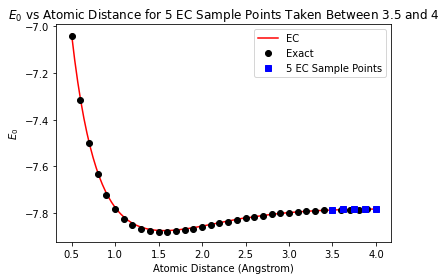

In [53]:
# Finally, we create a plot of everything all together

fig = plt.figure(1)
plt.figure(1)
plt.plot(EC_distances,EC_energies,'r-',label = 'EC') # plot EC results
plt.plot(exact_distances,exact_energies,'ko', label = 'Exact') # plot FD results
plt.plot(sample_distances,sample_energy,'bs', label = str(N_s) + ' EC Sample Points') # plot sample point eigen energies
plt.title('$E_{0}$ vs Atomic Distance for ' + str(N_s) + ' EC Sample Points Taken Between ' + str(s_min) + ' and ' + str(s_max))
plt.xlabel('Atomic Distance (Angstrom)')
plt.ylabel('$E_{0}$')
plt.legend(loc = 'upper right', fontsize = 'medium')
plt.show()

In [54]:
fig.savefig('EC_' + str(N_s) + '_Points_Between_' + str(s_min) + '_and_' + str(s_max) + '.png',dpi=300)